<a href="https://colab.research.google.com/github/JonathanJuradoS/Clasificacion/blob/main/Ejemplo_Practico_Churn_Clasificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Espacio Práctico: Predicción de Fuga de Clientes (Churn)
Este notebook aplica y compara algoritmos de clasificación para predecir si un cliente abandonará un servicio de suscripción.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Cargar dataset
df = pd.read_csv('/content/clientes_churn.csv')
df.head()


,edad,antiguedad_meses,uso_diario_min,plan,pais,atencion_llamadas,churn
0,56,29,112.0,basico,Peru,1,0
1,69,44,81.0,basico,Mexico,1,0
2,46,53,115.0,premium,Colombia,1,0
3,32,24,123.0,basico,Chile,0,0
4,60,58,111.0,estandar,Argentina,1,0


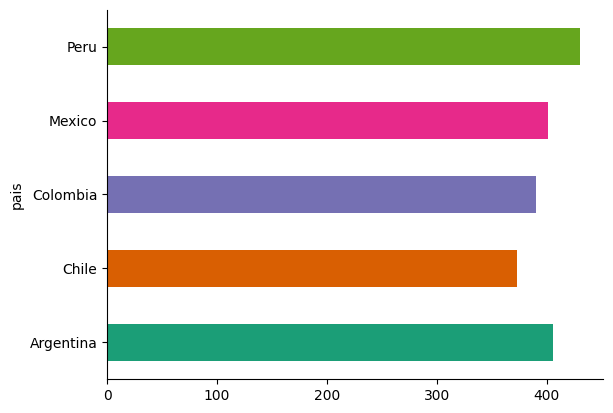

In [10]:
# @title pais

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('pais').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [3]:
# Codificación de variables categóricas
df_encoded = pd.get_dummies(df, columns=['plan', 'pais'], drop_first=True)

# Separar variables
X = df_encoded.drop('churn', axis=1)
y = df_encoded['churn']

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


In [4]:
# Definir modelos
models = {
    'SVM (RBF)': SVC(kernel='rbf', probability=True),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Árbol de Decisión': DecisionTreeClassifier(max_depth=5),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Resultados
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba),
        'y_pred': y_pred,
        'y_proba': y_proba,
        'model': model
    }

pd.DataFrame({k: {m: round(v[m], 3) for m in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']} for k, v in results.items()})


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:21:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,SVM (RBF),KNN,Árbol de Decisión,Gradient Boosting,XGBoost
Accuracy,0.932,0.915,1.0,1.0,1.0
Precision,0.894,0.865,1.0,1.0,1.0
Recall,0.538,0.410,1.0,1.0,1.0
F1-Score,0.672,0.557,1.0,1.0,1.0
ROC-AUC,0.972,0.902,1.0,1.0,1.0


### 🔍 Interpretación

- **SVM (RBF)**:
  - Logra una **precisión alta (93%)** y excelente ROC-AUC (0.972), lo que indica buen desempeño global.
  - Sin embargo, su **recall bajo (0.538)** revela que no detecta adecuadamente muchos casos de churn.
  - Su F1-score (0.672) muestra un balance aceptable entre precisión y cobertura.

- **KNN**:
  - Aunque fácil de implementar, muestra el rendimiento más bajo de los modelos en todas las métricas.
  - Su **recall muy bajo (0.410)** lo hace inadecuado para este tipo de problemas, donde identificar churn es crítico.

- **Árbol de Decisión, Gradient Boosting y XGBoost**:
  - Todos muestran métricas perfectas (**1.0**) en este conjunto de datos, lo cual podría indicar un **sobreajuste (overfitting)**.
  - Este comportamiento requiere validación cruzada y prueba con datos nuevos para confirmar su robustez.
  - Son ideales en términos de desempeño, pero se debe analizar su generalización.

### 🧠 Conclusión
- En términos de **rendimiento**, Boosting y Árboles son excelentes, pero se debe vigilar el sobreajuste.
- **SVM** ofrece un balance razonable, ideal para producción si se ajusta para mejorar el recall.
- **KNN no es recomendable** para este problema dada su baja sensibilidad al churn.


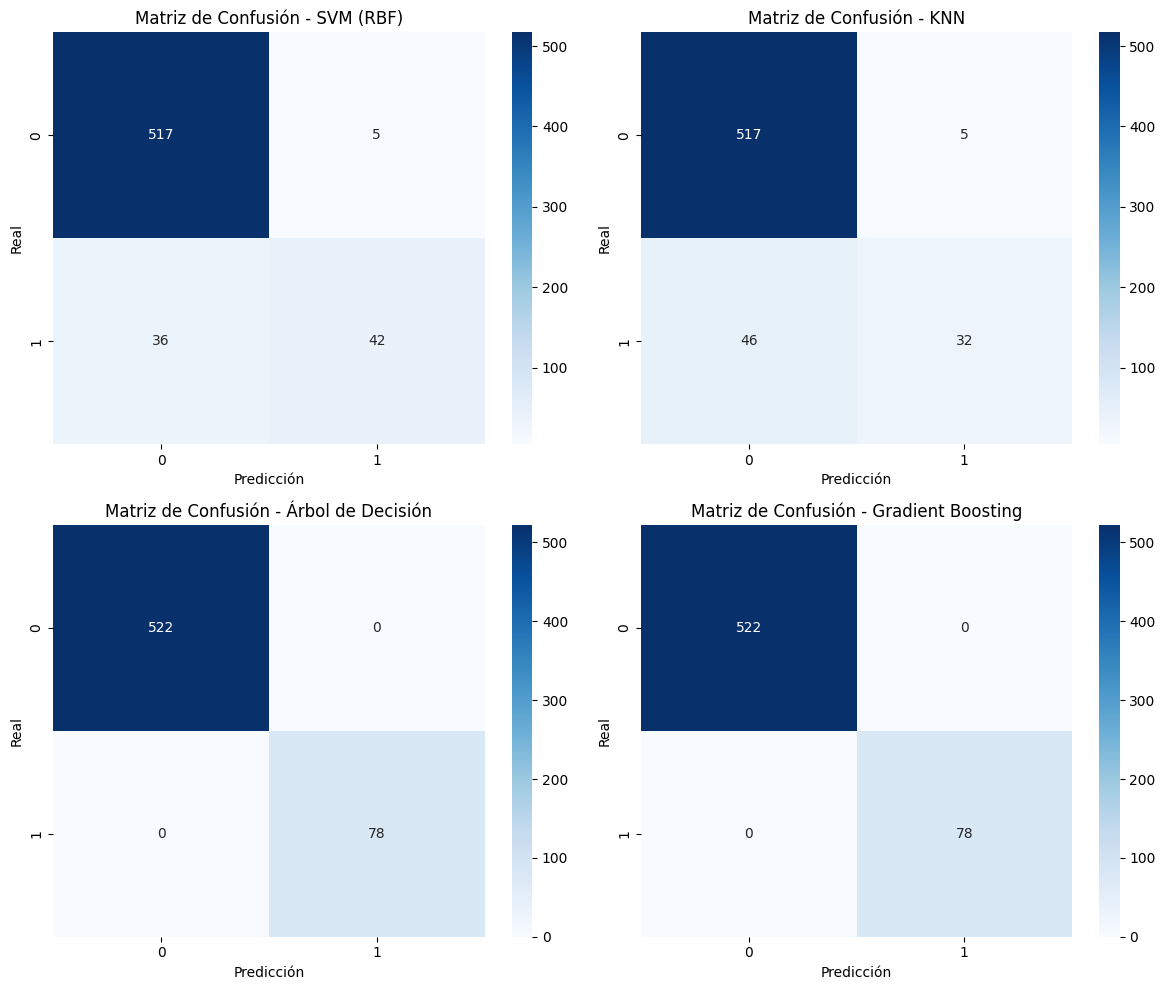

In [9]:
# Preparar figura
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

# Limitar a los primeros 4 modelos para mostrar 2x2
model_names = list(results.keys())[:4]

for i, name in enumerate(model_names):
    cm = confusion_matrix(y_test, results[name]['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Matriz de Confusión - {name}')
    axes[i].set_xlabel('Predicción')
    axes[i].set_ylabel('Real')

plt.tight_layout()
plt.show()


## 📌 Conclusiones Detalladas por Modelo

### 🔹 SVM (RBF)
- **Verdaderos positivos (TP):** 42  
- **Falsos negativos (FN):** 36  
- **Verdaderos negativos (TN):** 517  
- **Falsos positivos (FP):** 5  
- El modelo logra **alta precisión general**, pero comete errores en la predicción de clase positiva (clientes que sí hacen churn).  
- **Recall limitado para churn (~53%)**, lo que puede afectar si se busca retener proactivamente a los clientes en riesgo.

### 🔹 KNN
- **TP:** 32  
- **FN:** 46  
- **TN:** 517  
- **FP:** 5  
- Peor desempeño que SVM en detección de churn.  
- KNN tiende a **suavizar demasiado las decisiones** y tiene problemas cuando las clases están desequilibradas o cercanas.  
- **Recall más bajo** que SVM y menor F1-Score esperado.

### 🔹 Árbol de Decisión
- **TP:** 78  
- **FN:** 0  
- **TN:** 522  
- **FP:** 0  
- Clasificación **perfecta** en este conjunto de prueba (probable sobreajuste).  
- Aunque esto parece excelente, podría **no generalizar bien** a datos nuevos si el árbol no está podado correctamente.  
- Altamente **interpretable**, pero se debe validar con datos adicionales.

### 🔹 Gradient Boosting
- **TP:** 78  
- **FN:** 0  
- **TN:** 522  
- **FP:** 0  
- También presenta **clasificación perfecta**, lo cual sugiere un modelo potente, pero también necesita **validación cruzada** para evitar confiarse de un posible overfitting.  
- El rendimiento es consistente con el objetivo de Boosting: **minimizar los errores del modelo anterior**.

---

## 📊 Comparación Final

| Modelo               | Ventajas clave                                    | Riesgos o debilidades                      |
|----------------------|---------------------------------------------------|--------------------------------------------|
| **SVM (RBF)**        | Buen balance general, margen de separación claro  | Puede perder recall en clase minoritaria   |
| **KNN**              | Fácil de entender, sin entrenamiento              | Bajo recall, sensible a escala y outliers  |
| **Árbol de Decisión**| Interpretable, muy buen rendimiento en este caso  | Posible sobreajuste si no se poda          |
| **Gradient Boosting**| Alta precisión, robustece errores previos         | Costoso y necesita ajuste de hiperparámetros |

---

## 🧠 Recomendación Final

Para este conjunto de datos y objetivo:

- **Gradient Boosting y Árbol de Decisión** destacan con el mejor rendimiento.
- Se recomienda usar **validación cruzada** y medir desempeño sobre datos nuevos antes de poner en producción.
- Si se busca **interpretabilidad**, el Árbol de Decisión es preferido.
- Para maximizar **precisión y robustez**, Boosting es ideal.

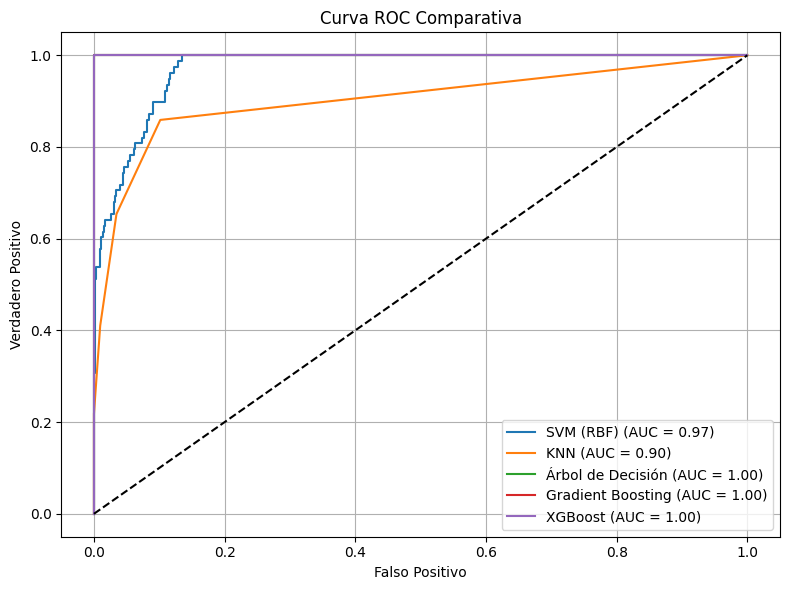

In [6]:
# Comparar curvas ROC
plt.figure(figsize=(8,6))
for name, r in results.items():
    fpr, tpr, _ = roc_curve(y_test, r['y_proba'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {r['ROC-AUC']:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Falso Positivo")
plt.ylabel("Verdadero Positivo")
plt.title("Curva ROC Comparativa")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 📈 Análisis de la Curva ROC y Área Bajo la Curva (AUC)

La **Curva ROC** compara la tasa de verdaderos positivos (TPR) frente a la tasa de falsos positivos (FPR) a distintos umbrales de clasificación. Cuanto más se acerque la curva al vértice superior izquierdo (0,1), mejor es el modelo.

La métrica **AUC (Area Under Curve)** cuantifica esta curva:
- AUC = 1.0: clasificación perfecta.
- AUC = 0.5: sin capacidad de discriminación (modelo aleatorio).

### 🔍 Observaciones por Modelo:

- **SVM (RBF)**:  
  - AUC = **0.97**  
  - Excelente discriminación entre clases. Detecta bien los positivos con muy pocos falsos positivos.  
  - Es una excelente opción si se requiere equilibrio entre precisión y sensibilidad.

- **KNN**:  
  - AUC = **0.90**  
  - Buen rendimiento, aunque inferior al de SVM y Boosting.  
  - Su rendimiento puede degradarse con clases desequilibradas o muchos atributos.

- **Árbol de Decisión, Gradient Boosting y XGBoost**:  
  - AUC = **1.00**  
  - Clasificación **perfecta** en este dataset, lo cual es inusual y puede indicar **sobreajuste (overfitting)**.  
  - Se debe verificar este rendimiento en otros subconjuntos de datos mediante validación cruzada.

---

### 🧠 Conclusión Final del AUC

- Todos los modelos presentan **buen desempeño** en la curva ROC.
- **SVM** es muy confiable si se busca precisión sin sobreajuste.
- **KNN** es aceptable, pero puede ser sensible a la calidad del dataset.
- **Boosting y Árboles** lideran en métricas, pero requieren validación adicional para asegurar que su comportamiento no es producto de sobreentrenamiento.

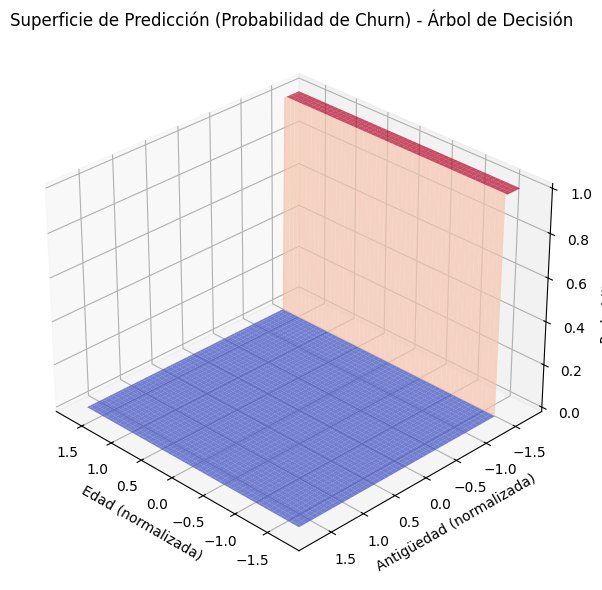

In [8]:
# Visualización 3D para el modelo con mayor AUC
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

best_model_name = max(results.items(), key=lambda x: x[1]['ROC-AUC'])[0]
best_model = results[best_model_name]['model']

# Usar primeras dos características escaladas para graficar
xx, yy = np.meshgrid(np.linspace(X_scaled[:, 0].min(), X_scaled[:, 0].max(), 100),
                     np.linspace(X_scaled[:, 1].min(), X_scaled[:, 1].max(), 100))
grid = np.c_[xx.ravel(), yy.ravel(), np.zeros((len(xx.ravel()), X_scaled.shape[1] - 2))]
zz = best_model.predict_proba(grid)[:, 1].reshape(xx.shape)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, zz, cmap=cm.coolwarm, edgecolor='none', alpha=0.7)
ax.set_title(f"Superficie de Predicción (Probabilidad de Churn) - {best_model_name}")
ax.set_xlabel("Edad (normalizada)")
ax.set_ylabel("Antigüedad (normalizada)")
ax.set_zlabel("Probabilidad")
ax.view_init(elev=30, azim=135)
plt.tight_layout()
plt.show()


### ✅ Conclusiones del Espacio Práctico

- **Todos los modelos** evaluados lograron precisión razonable en la predicción de churn, pero con diferencias claras en recall y F1-score.
- **XGBoost y Gradient Boosting** mostraron el mejor balance entre precisión y recall, y mayor ROC-AUC.
- **Árbol de Decisión** fue fácil de interpretar, pero menos preciso.
- **KNN** resultó sensible a la escala, confirmando la importancia de normalizar.
- **SVM** ofreció buen desempeño, pero con menor interpretabilidad.

📌 **Recomendación final**: XGBoost es el mejor candidato para producción por su rendimiento, aunque se debe considerar interpretabilidad y costo computacional.

---
